In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize_with_pad
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dropout, LeakyReLU, MaxPooling2D, UpSampling2D

In [ ]:
BASE_IMAGE_PATH = '../input/guns-object-detection/Images'
BASE_LABELS_PATH = '../input/guns-object-detection/Labels'
TARGET_IMAGE_SIZE = (256, 256)
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 50
VAL_SPLIT = 0.2

In [ ]:
image_data = []
image_labels = []

image_count = len(os.listdir(BASE_IMAGE_PATH))

for i in range(1, image_count + 1):
    img = load_img(os.path.join(BASE_IMAGE_PATH, str(i) + '.jpeg'))
    img = img_to_array(img, dtype = 'uint8')
    image_data.append(img)

    label_mask = np.zeros((*img.shape[:2], 1))

    with open(os.path.join(BASE_LABELS_PATH, str(i) + '.txt'), 'r') as label_file:
        l_count = int(label_file.readline())

        for i in range(l_count):
            box = list(map(int, label_file.readline().split()))
            label_mask[box[1]:box[3], box[0]:box[2]] = 1.0

    image_labels.append(label_mask)

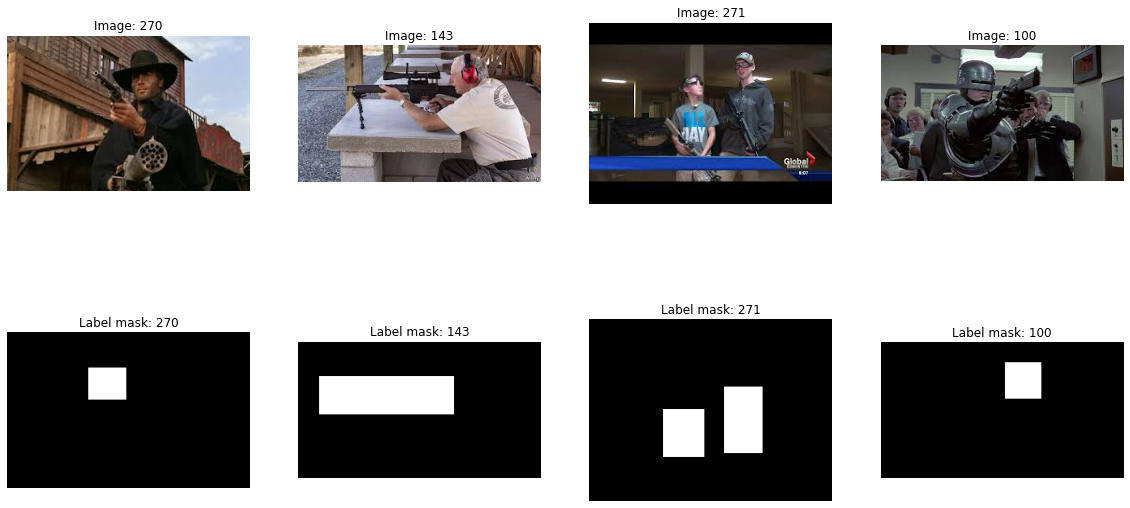

In [ ]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in enumerate(np.random.randint(0, image_count, size = 4)):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])

    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [ ]:
for i in range(image_count):
    image_data[i] = resize_with_pad(image_data[i], *TARGET_IMAGE_SIZE).numpy() / 255.0
    image_labels[i] = resize_with_pad(image_labels[i], *TARGET_IMAGE_SIZE).numpy()

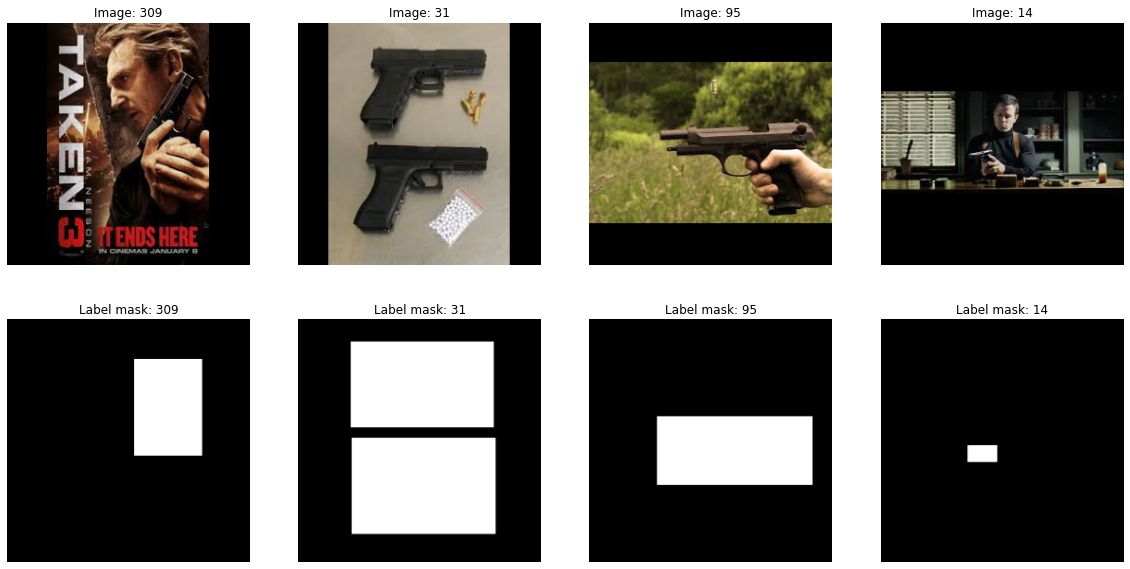

In [ ]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in enumerate(np.random.randint(0, image_count, size = 4)):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])

    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [ ]:
image_data = np.array(image_data)
image_labels = np.array(image_labels)

In [ ]:
def weighted_bce(y_true, y_pred):
    LOSS_WEIGHT = 8
    loss_ones = LOSS_WEIGHT * y_true * tf.math.log(y_pred + 1e-7)
    loss_zeros = (1 - y_true) * tf.math.log(1 - y_pred + 1e-7)
    loss = - loss_ones - loss_zeros
    return tf.reduce_mean(loss)

In [ ]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*TARGET_IMAGE_SIZE, 3), activation = LeakyReLU()),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),
    MaxPooling2D(),

    Conv2D(128, 3, padding = 'same', activation = LeakyReLU()),
    Dropout(0.1),

    UpSampling2D(),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),

    UpSampling2D(),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU()),

    Dropout(0.1),
    Conv2D(1, 3, padding = 'same', activation = 'sigmoid'),
])

model.compile(optimizer = Adam(LEARNING_RATE), loss = weighted_bce)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 128)     0

In [ ]:
%%time

history = model.fit(image_data, image_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VAL_SPLIT, verbose = 1)

Epoch 1/50
11/17 [==================>...........] - ETA: 1:16 - loss: 1.0846

In [ ]:
plt.subplots(nrows = 3, ncols = 4, figsize = (20, 10))

indices_to_predict = np.random.randint(0, image_count, size = 4)

for i, img_index in enumerate(indices_to_predict):
    preds = model.predict(image_data[indices_to_predict])

    masked_images = preds * image_data[indices_to_predict]

    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])

    plt.subplot(3, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Predicted mask: {img_index}')
    plt.imshow(preds[i], cmap = 'gray')

    plt.subplot(3, 4, i + 9)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Masked image: {img_index}')
    plt.imshow(masked_images[i])
plt.show()

# Improvements required
- Image augmentation
- Custom loss function to give more weightage to the value 1 in the target - **Done**